## Insurance Charge - Linear Regression with pytorch


In [1]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

In [11]:
url = "https://raw.githubusercontent.com/stedy/Machine-Learning-with-R-datasets/master/insurance.csv"
df = pd.read_csv(url)

## Encode categorical variables

In [12]:
df['sex'] = df['sex'].map({'male': 1, 'female': 0})
df['smoker'] = df['smoker'].map({'yes': 1, 'no': 0})

One-hot encode region (drop first to avoid multicollinearity)

In [13]:
df = pd.get_dummies(df, columns=['region'], drop_first=True)

## Feature engineering

In [14]:
# Interaction terms
df['bmi_smoker'] = df['bmi'] * df['smoker']
df['age_smoker'] = df['age'] * df['smoker']

# Polynomial terms
df['age2'] = df['age'] ** 2
df['bmi2'] = df['bmi'] ** 2

## Log-transform

In [15]:
df['charges_log'] = np.log(df['charges'])

## Data Split

In [16]:
from sklearn.model_selection import train_test_split

X = df.drop(columns=['charges', 'charges_log', 'age', 'bmi'])
y = df['charges_log'].values.reshape(-1, 1)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

In [17]:
print(X_train)

      sex  children  smoker  region_northwest  region_southeast  \
560     0         2       0              True             False   
1285    0         0       0             False             False   
1142    0         0       0             False              True   
969     0         5       0             False              True   
486     0         3       0              True             False   
...   ...       ...     ...               ...               ...   
1095    0         4       0             False             False   
1130    0         5       0             False              True   
1294    1         0       0             False             False   
860     0         2       1             False             False   
1126    1         0       0             False             False   

      region_southwest  bmi_smoker  age_smoker  age2         bmi2  
560              False         0.0           0  2116   398.002500  
1285             False         0.0           0  2209   591.

## Normalize Feature

In [18]:
X_mean = X_train.mean(axis=0)
X_std = X_train.std(axis=0)

X_train = (X_train - X_mean) / X_std
X_test  = (X_test  - X_mean) / X_std

In [19]:
X_train = X_train.values.astype(float)
X_test  = X_test.values.astype(float)

## Convert to PyTorch Tensors

In [20]:
X_train_t = torch.tensor(X_train, dtype=torch.float32)
y_train_t = torch.tensor(y_train, dtype=torch.float32)

X_test_t = torch.tensor(X_test, dtype=torch.float32)
y_test_t = torch.tensor(y_test, dtype=torch.float32)

## Linear Regression

In [21]:
model = nn.Linear(X_train_t.shape[1], 1)

In [23]:
# Loss
criterion = nn.MSELoss()

In [24]:
# Optimizer
optimizer = torch.optim.AdamW(
    model.parameters(),
    lr=0.01,
    weight_decay=1e-2
)

## Build Model

In [25]:
epochs = 3000
losses = []

for epoch in range(epochs):
    y_pred = model(X_train_t)
    loss = criterion(y_pred, y_train_t)

    loss.backward()
    optimizer.step()
    optimizer.zero_grad()

    losses.append(loss.item())

    if epoch % 500 == 0:
        print(f"Epoch {epoch}, Loss: {loss.item():.4f}")

Epoch 0, Loss: 82.4567
Epoch 500, Loss: 23.0837
Epoch 1000, Loss: 4.8151
Epoch 1500, Loss: 0.8914
Epoch 2000, Loss: 0.2993
Epoch 2500, Loss: 0.2113


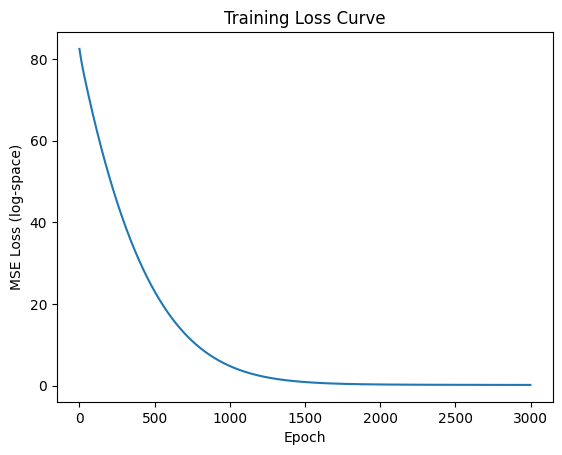

In [27]:
# Plot training Loss
plt.plot(losses)
plt.xlabel("Epoch")
plt.ylabel("MSE Loss (log-space)")
plt.title("Training Loss Curve")
plt.show()

## Evaluate Model

In [28]:
with torch.no_grad():
    y_test_pred_log = model(X_test_t).numpy()

y_test_pred = np.exp(y_test_pred_log)
y_test_actual = np.exp(y_test)

In [29]:
from sklearn.metrics import mean_squared_error, r2_score

rmse = np.sqrt(mean_squared_error(y_test_actual, y_test_pred))
r2 = r2_score(y_test_actual, y_test_pred)

print("RMSE:", rmse)
print("R2:", r2)

RMSE: 5687.710428557163
R2: 0.7916243848933985


**Note:** How to see which parameter impacts

In [30]:
for name, param in model.named_parameters():
    print(name, param[:5])

weight tensor([[-0.0426,  0.1492,  0.4531, -0.0269, -0.0547, -0.0611,  0.6807, -0.5266,
          0.5647, -0.0032]], grad_fn=<SliceBackward0>)
bias tensor([8.9612], grad_fn=<SliceBackward0>)
